In [1]:
import pandas as pd
import gensim

In [2]:
DATA_DIR = "../../data/raw/"
INPUT_FILE_NAME = 'cleaned.parquet'
OUTPUT_FILE_NAME = 'cleaned_squashed.parquet'

In [3]:
df = pd.read_parquet(DATA_DIR + INPUT_FILE_NAME)
df.head()

,speaker,headline,description,duration,tags,transcript,WC,clean_transcript,clean_transcript_string
0,Al Gore,Averting the climate crisis,With the same humor and humanity he exuded in ...,0:16:17,"cars,alternative energy,culture,politics,scien...","0:14\r\r\rThank you so much, Chris.\rAnd it's ...",2281.0,"[thank, chris, truly, great, honor, opportunit...",thank chris truly great honor opportunity come...
1,Amy Smith,Simple designs to save a life,Fumes from indoor cooking fires kill more than...,0:15:06,"MacArthur grant,simplicity,industrial design,a...","0:11\r\r\rIn terms of invention,\rI'd like to ...",2687.0,"[term, invention, like, tell, tale, favorite, ...",term invention like tell tale favorite project...
2,Ashraf Ghani,How to rebuild a broken state,Ashraf Ghani's passionate and powerful 10-minu...,0:18:45,"corruption,poverty,economics,investment,milita...","0:12\r\r\rA public, Dewey long ago observed,\r...",2506.0,"[public, dewey, long, ago, observe, constitute...",public dewey long ago observe constitute discu...
3,Burt Rutan,The real future of space exploration,"In this passionate talk, legendary spacecraft ...",0:19:37,"aircraft,flight,industrial design,NASA,rocket ...","0:11\r\r\rI want to start off by saying, Houst...",3092.0,"[want, start, say, houston, problem, enter, se...",want start say houston problem enter second ge...
4,Chris Bangle,Great cars are great art,American designer Chris Bangle explains his ph...,0:20:04,"cars,industrial design,transportation,inventio...","0:12\r\r\rWhat I want to talk about is, as bac...",3781.0,"[want, talk, background, idea, car, art, actua...",want talk background idea car art actually mea...


In [4]:
tags = df['tags'].str.replace(', ', ',').str.lower().str.strip()
split_tags = tags.str.split(',')
tag_counts_per_talk = split_tags.apply(len)

joined_tags = tags.str.cat(sep=',').split(',')
all_tags_w_dup = pd.Series(joined_tags)

tag_counts = all_tags_w_dup.value_counts()


In [5]:
tag_documents = tags.str.cat(sep='_').split('_')
def tokenise(documents):
    for string in documents:
        yield gensim.utils.simple_preprocess(string)
tag_documents = list(tokenise(tag_documents))

transcript_documents = df['clean_transcript'].map(lambda x: x.tolist())
transcript_documents = list(transcript_documents)

In [6]:
tag_model = gensim.models.Word2Vec(tag_documents,size=150,window=5,min_count=2,workers=4)
tag_model.train(tag_documents,total_examples=len(tag_documents),epochs=10)

transcript_model = gensim.models.Word2Vec(transcript_documents,size=150,window=5,min_count=2,workers=4)
transcript_model.train(transcript_documents,total_examples=len(transcript_documents),epochs=10)

(17855508, 19253440)

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model,squash):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
    count = 0
    for word in model.wv.vocab:
        # TODO get the labels
        if squash:
            if word in squash_list:
                tokens.append(model[word])
                labels.append(word)    
        else:
            tokens.append(model[word])
            labels.append(word)


    # set the t-sne values
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=3500, random_state=32)
    new_values = tsne_model.fit_transform(tokens)
    # TODO fit the t-sne model

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [8]:
tag_cutoff = int(0.01*len(df.index))

squashed_tags = pd.DataFrame(tag_counts)
squashed_tags = squashed_tags[(squashed_tags[0]>tag_cutoff)]
squash_list = list(squashed_tags.index.values)


In [9]:
def squashing (x):
    original_tags = x
    tags = original_tags.replace(', ', ',').lower().strip()
    split_tags = tags.split(',')
    final_tags = []
    for tag in split_tags:
        if tag in squash_list:
            final_tags.append(tag)
    final_string = ','.join(final_tags)
    return final_string

In [10]:
df['squash_tags'] = df['tags']
df['squash_tags'] = df['squash_tags'].map(lambda x: squashing(x))
df.head()

,speaker,headline,description,duration,tags,transcript,WC,clean_transcript,clean_transcript_string,squash_tags
0,Al Gore,Averting the climate crisis,With the same humor and humanity he exuded in ...,0:16:17,"cars,alternative energy,culture,politics,scien...","0:14\r\r\rThank you so much, Chris.\rAnd it's ...",2281.0,"[thank, chris, truly, great, honor, opportunit...",thank chris truly great honor opportunity come...,"alternative energy,culture,politics,science,cl..."
1,Amy Smith,Simple designs to save a life,Fumes from indoor cooking fires kill more than...,0:15:06,"MacArthur grant,simplicity,industrial design,a...","0:11\r\r\rIn terms of invention,\rI'd like to ...",2687.0,"[term, invention, like, tell, tale, favorite, ...",term invention like tell tale favorite project...,"industrial design,alternative energy,invention..."
2,Ashraf Ghani,How to rebuild a broken state,Ashraf Ghani's passionate and powerful 10-minu...,0:18:45,"corruption,poverty,economics,investment,milita...","0:12\r\r\rA public, Dewey long ago observed,\r...",2506.0,"[public, dewey, long, ago, observe, constitute...",public dewey long ago observe constitute discu...,"poverty,economics,investment,culture,politics,..."
3,Burt Rutan,The real future of space exploration,"In this passionate talk, legendary spacecraft ...",0:19:37,"aircraft,flight,industrial design,NASA,rocket ...","0:11\r\r\rI want to start off by saying, Houst...",3092.0,"[want, start, say, houston, problem, enter, se...",want start say houston problem enter second ge...,"industrial design,invention,engineering,entrep..."
4,Chris Bangle,Great cars are great art,American designer Chris Bangle explains his ph...,0:20:04,"cars,industrial design,transportation,inventio...","0:12\r\r\rWhat I want to talk about is, as bac...",3781.0,"[want, talk, background, idea, car, art, actua...",want talk background idea car art actually mea...,"industrial design,transportation,invention,des..."


In [11]:
squash_tags = df['squash_tags'].str.replace(', ', ',').str.lower().str.strip()
squash_tag_documents = squash_tags.str.cat(sep='_').split('_')
squash_tag_documents = list(tokenise(squash_tag_documents))

squash_tag_model = gensim.models.Word2Vec(squash_tag_documents,size=150,window=5,min_count=2,workers=4)
squash_tag_model.train(squash_tag_documents,total_examples=len(tag_documents),epochs=10)


(97262, 177180)

C:\Users\JSaw\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


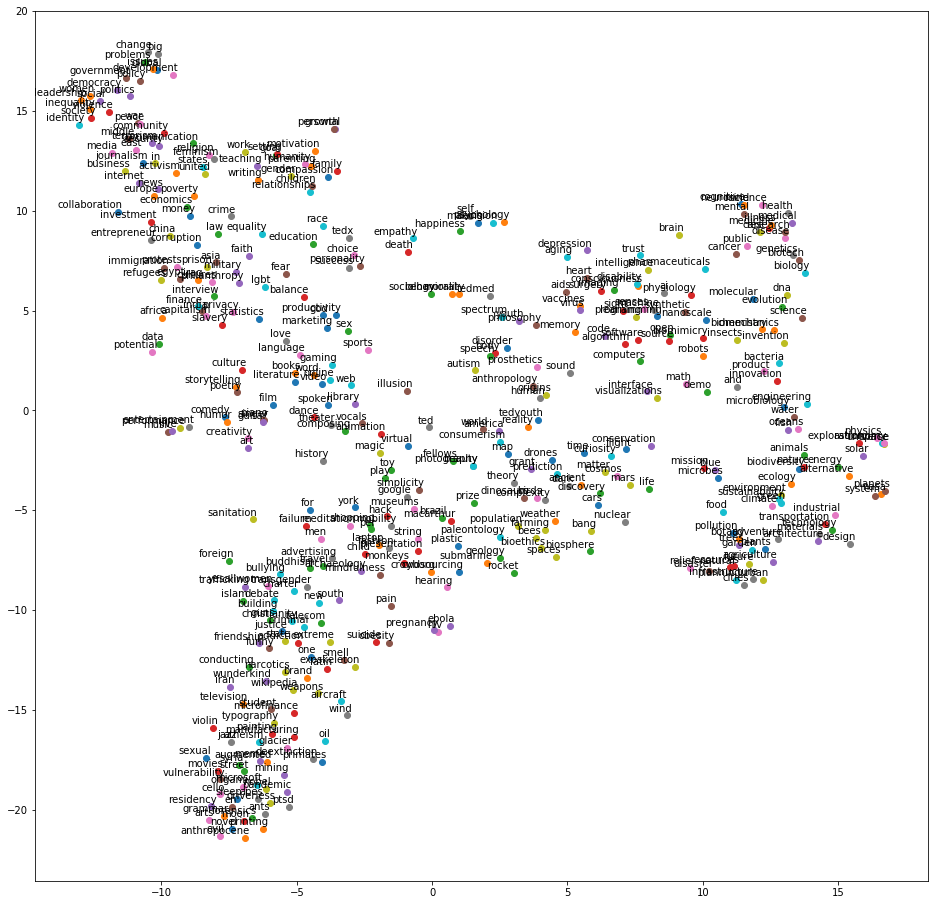

C:\Users\JSaw\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


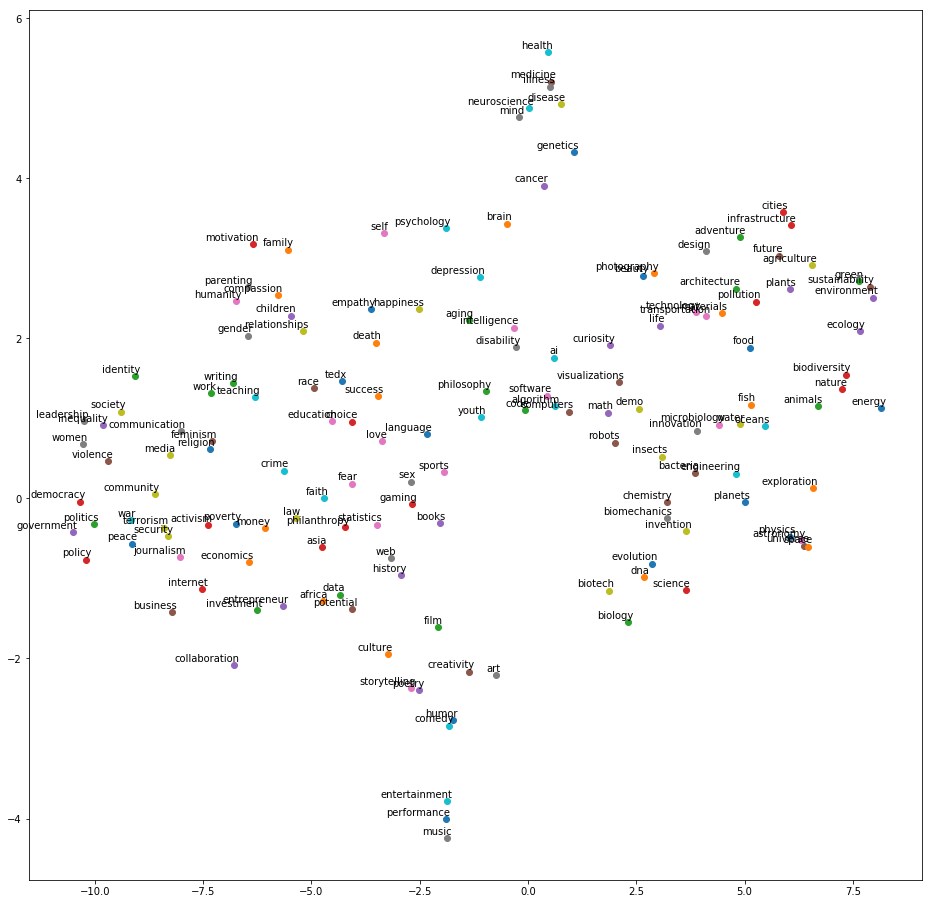

In [12]:
tsne_plot(tag_model,False)
tsne_plot(tag_model,True)

C:\Users\JSaw\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


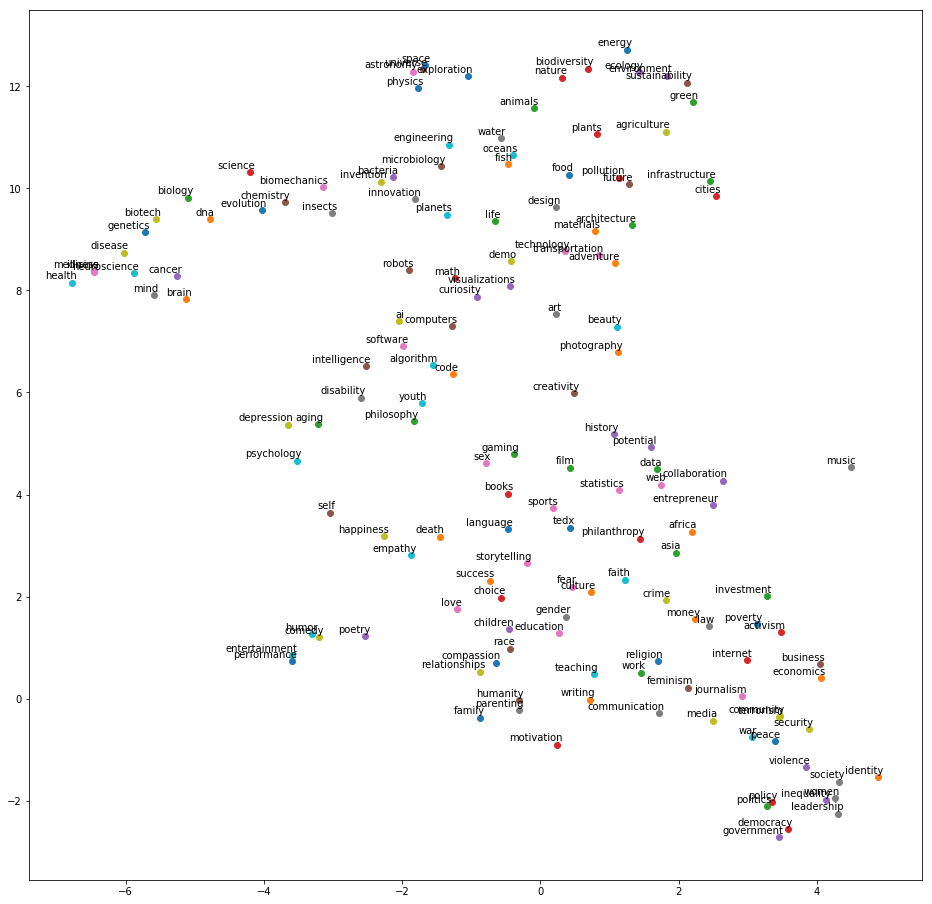

In [13]:
tsne_plot(squash_tag_model,True)

In [14]:
# df[df['tags']=='']

In [15]:
# df.to_pickle("./squashed_processed_data.pkl")

In [16]:
# df['tags']

In [17]:
w = 'alternative'
tag_model.wv.most_similar(positive=w,topn=10)
# transcript_model.wv.most_similar(positive=w1,topn=10)

[('energy', 0.994419515132904),
 ('solar', 0.973480761051178),
 ('architecture', 0.9339233040809631),
 ('transportation', 0.9243452548980713),
 ('materials', 0.9230737686157227),
 ('exploration', 0.9230621457099915),
 ('nature', 0.919122576713562),
 ('system', 0.9156764149665833),
 ('industrial', 0.9117905497550964),
 ('oceans', 0.8985277414321899)]

In [18]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [30]:
nlp_list = []
for i in range(len(squash_list)):
    nlp_list.append(nlp(squash_list[i]))

0.5343137648031807

In [42]:
simlist = []
tagsimcount = [0]*len(squash_list)
tagsimdict = {el:[] for el in squash_list}
for outer in range(len(nlp_list)):
    for inner in range(len(nlp_list)):
        if inner<outer:
            sim = nlp_list[outer].similarity(nlp_list[inner])
            if sim > 0.7:
                ow = squash_list[outer]
                iw = squash_list[inner]      
                simlist.append([ow,iw,sim])
                tagsimcount[outer] += 1
                tagsimcount[inner] += 1
                tagsimdict[ow].append(iw)
                tagsimdict[iw].append(ow)
                
                
print(simlist)
print(tagsimcount)
print(tagsimdict)

[['innovation', 'technology', 0.7079067070176172], ['social change', 'global issues', 0.7065620952751144], ['biology', 'science', 0.7382837284679973], ['health care', 'health', 0.9405256933992137], ['medical research', 'health', 0.7061961737620224], ['medical research', 'medicine', 0.7226795982245955], ['medical research', 'health care', 0.7060567467741142], ['neuroscience', 'biology', 0.7005146357683555], ['neuroscience', 'psychology', 0.7079842954170484], ['climate change', 'global issues', 0.7091930953842466], ['climate change', 'social change', 0.7279424635875136], ['potential', 'future', 0.7064201527499164], ['physics', 'science', 0.72971193171557], ['live music', 'music', 0.8868716879708112], ['genetics', 'biology', 0.758615052729121], ['mental health', 'health', 0.9083845435184473], ['mental health', 'health care', 0.8659043206099354], ['global development', 'global issues', 0.8402497479570554], ['cognitive science', 'science', 0.8304685057515299], ['cognitive science', 'psychol

In [43]:
# replace tags
# SPLIT UP: 'women in business' -> 'women','business'
# GENERALISE: 'education','teaching' -> 'education'
# REMAIN: 'africa', 'asia' -> 'africa', 'asia'

In [44]:
tagsimdict['teaching']

['education']

In [45]:
longtags = []
for t in squash_list:
    if ' ' in t:
        longtags.append(t)
print(longtags)

['global issues', 'social change', 'ted fellows', 'health care', 'medical research', 'personal growth', 'climate change', 'big problems', 'live music', 'mental health', 'global development', 'cognitive science', 'ted brain trust', 'public health', 'product design', 'social media', 'science and art', 'alternative energy', 'molecular biology', 'middle east', 'interface design', 'industrial design', 'women in business', 'ted prize', 'urban planning', 'united states']


In [47]:
potential = []
for lt in longtags:
    split = lt.split()
    new = []
    for i in range(len(split)):
        if split[i] in squash_list:
            new.append(split[i])
    if new == []:
        potential.append(lt)
    else:
        potential.append(new)
print(potential)

['global issues', 'social change', 'ted fellows', ['health'], 'medical research', 'personal growth', 'climate change', 'big problems', ['music'], ['health'], 'global development', ['science'], ['brain'], ['health'], ['design'], ['media'], ['science', 'art'], ['energy'], ['biology'], 'middle east', ['design'], ['design'], ['women', 'business'], 'ted prize', 'urban planning', 'united states']
